# Random Forest Regressor using TA features to Predict BTC future price moves
This notebook is a work in progress. We create features as independent columns in the dataframe. We then try to build a model using a random forest regression to use those features to predict the next N periods into the future for the price change of an asset. The results are pretty impressive so I feel like we are doing something wrong. Feel free to play around with it, I think I documented things in line pretty well so you can play along.

In [3]:
import vectorbt as vbt
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import logging
import pickle
from tqdm import tqdm




If you do not have a datafile you can use the notebook `get-data.ipynb` to download some bitcoin data. You can store it in the `/data` folder as `btc.csv`

In [4]:

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

logging.info(f"Loading data")
data = pd.read_csv('../data/btc.csv', index_col=0, parse_dates=True) # I'm using minutely data

# just keep the 'Close' and 'Volume' columns
data = data[['Close', 'Volume']]


2023-03-21 11:42:19,161 - INFO - Loading data


Let's add some features. We will do just a few right now but we can add more later in the notebook

In [5]:
# Create an indicator of the EMA of the close price
ema1_period = 20000
ema2_period = 5000
sma1_period = 10000
sma2_period = 1000
# add the indicators to the dataframe
data.ta.ema(close='Close', length=ema1_period, append=True)
data.ta.ema(close='Close', length=ema2_period, append=True)
data.ta.sma(close='Close', length=sma1_period, append=True)
data.ta.sma(close='Close', length=sma2_period, append=True)
data.dropna(inplace=True)

# Create signals for the EMA and SMA (I was trying to get it into a magnitude format ie. how much is the market above/below the EMA/SMA)
data['ema1_signal'] = (data['Close']/data[f'EMA_{ema1_period}'])-1
data['ema2_signal'] = (data['Close']/data[f'EMA_{ema2_period}'])-1
data['sma1_signal'] = (data['Close']/data[f'SMA_{sma1_period}'])-1
data['sma2_signal'] = (data['Close']/data[f'SMA_{sma2_period}'])-1

# Create forecast column for the target variable
forecast = 30 # 30 mins
data[f'forecast_{forecast}'] = data['Close'].shift(-forecast).pct_change(forecast).dropna()
data['future'] = data['Close'].shift(-forecast)
data.dropna(inplace=True)

df = data.copy()
logging.info(f"Forecasting {forecast} mins fwd.")
logging.info(f'Using {ema1_period} and {ema2_period} ema periods')
logging.info(f'Using {sma1_period} and {sma2_period} sma periods')


2023-03-21 11:42:21,111 - INFO - Forecasting 30 mins fwd.
2023-03-21 11:42:21,112 - INFO - Using 20000 and 5000 ema periods
2023-03-21 11:42:21,112 - INFO - Using 10000 and 1000 sma periods


In [6]:
# Create the features (X) and target (y) data using numpy
X = df[['ema1_signal', 'ema2_signal', 'sma1_signal', 'sma2_signal', 'Volume']].iloc[:-forecast].values # signal and volume
y = df['Close'].pct_change(forecast).dropna().iloc[:-forecast].values.reshape(-1, 1) # future

# Split the data into training and testing sets and make sure they are the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Create the model and fit it to the data
logging.info(f"Creating model")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y.ravel()) # Fitting the model takes a few minutes
logging.info(f"Model fitted")
y_val = df['Close'].shift(-forecast).pct_change(forecast).dropna() # future
X_val = df[['ema1_signal', 'ema2_signal', 'sma1_signal', 'sma2_signal', 'Volume']][-len(y_val):] # signals and volume
y_val = y_val.values.reshape(-1, 1) # reshape to 2D
# make predictions
logging.info(f"Making predictions")
y_pred = model.predict(X_val.values) # make predictions is pretty quick
logging.info(f"Predictions made")

# remove NaNs and infinities
valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_val.ravel()) # remove NaNs
y_pred = y_pred[valid_indices]
y_val = y_val[valid_indices]


2023-03-21 11:42:21,139 - INFO - Creating model
2023-03-21 11:43:58,639 - INFO - Model fitted
2023-03-21 11:43:58,693 - INFO - Making predictions
2023-03-21 11:44:00,864 - INFO - Predictions made


In [7]:
def calculate_and_print_results(y_val, y_pred, threshold=0.0005):

    mse = mean_squared_error(y_pred, y_val)
    rmse = np.sqrt(mse)
    correct_predictions = np.abs(y_pred - y_val.ravel()) <= threshold
    direction_correct = (np.sign(y_pred) == np.sign(y_val.ravel())).astype(int)
    direction_accuracy = direction_correct.mean() * 100
    accuracy = np.mean(correct_predictions) * 100
    r2 = r2_score(y_val, y_pred)

    print(f"For a threshold of: {threshold}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse:.4f}")
    # print accuracy within 4 decimal places
    print(f"Accuracy: {accuracy:.4f}%")
    print(f"Direction Accuracy: {direction_accuracy:.4f}% This happened {direction_correct.sum()} times out of {len(direction_correct)}")
    print(f"R-squared: {r2:.4f}")
    results = {
        'mse': mse,
        'rmse': rmse,
        'accuracy': accuracy,
        'direction_accuracy': direction_accuracy,
        'r2': r2
    }
    return results

stats = calculate_and_print_results(y_val, y_pred, threshold=0.001)


For a threshold of: 0.001
MSE: 1.1840150881180445e-06
RMSE: 0.0011
Accuracy: 83.0634%
Direction Accuracy: 94.2566% This happened 530426 times out of 562747
R-squared: 0.9468


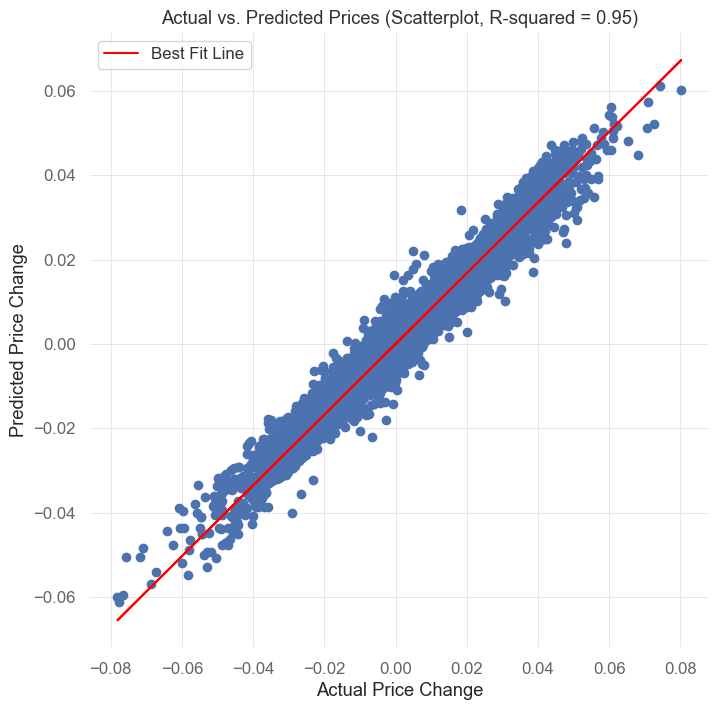

In [8]:
# Create a scatter plot of the predictions versus the actual values
def plot_scatter(y_val, y_pred, r2):

    # Fit a line of best fit to the data
    coeffs = np.polyfit(y_val.ravel(), y_pred.ravel(), 1)
    line = coeffs[0] * y_val.ravel() + coeffs[1]

    # Plot actual vs predicted prices as scatterplot
    plt.figure(figsize=(8, 8))
    plt.scatter(y_val, y_pred)
    plt.xlabel('Actual Price Change')
    plt.ylabel('Predicted Price Change')
    plt.title(f'Actual vs. Predicted Prices (Scatterplot, R-squared = {r2:.2f})')

    # Add best fit line
    plt.plot(y_val.ravel(), line, color='red', label='Best Fit Line')
    plt.legend()

    plt.show()
# Run the function
plot_scatter(y_val, y_pred, stats['r2'])

In [9]:
# Save the model
file_name = f'../models/rf_model_ema{ema1_period}-ema{ema2_period}-sma{sma1_period}-sma{sma2_period}-f{forecast}.pkl'
with open(file_name,  'wb') as file:
    pickle.dump(model, file)

# Create additional features using Pandas_TA
Pandas_ta has a nice capability to create your own indicators as a `Strategy` class. The following are features that I played around with. 

In [10]:
momo_bands_sma_ta = [
    {"kind":"sma", "length": 1000},
    {"kind":"sma", "length": 20000},
    {"kind":"ema", "length": 10000},
    {"kind":"ema", "length": 5000},
    {"kind":"bbands", "length": 2000, "ddof": 0},
    {"kind":"macd"},
    {"kind":"rsi"},
    {"kind":"log_return", "cumulative": True},
    {"kind":"sma", "close": "CUMLOGRET_1", "length": 50, "suffix": "CUMLOGRET"},
]
momo_bands_sma_strategy = ta.Strategy(
    "Momo, Bands, MAs and Cumulative Log Returns", # name
    momo_bands_sma_ta, # ta
    "MACD, RSI, Momo with BBANDS and EMAs, SMAs and Cumulative Log Returns" # description
)
momo_bands_sma_strategy

Strategy(name='Momo, Bands, MAs and Cumulative Log Returns', ta=[{'kind': 'sma', 'length': 1000}, {'kind': 'sma', 'length': 20000}, {'kind': 'ema', 'length': 10000}, {'kind': 'ema', 'length': 5000}, {'kind': 'bbands', 'length': 2000, 'ddof': 0}, {'kind': 'macd'}, {'kind': 'rsi'}, {'kind': 'log_return', 'cumulative': True}, {'kind': 'sma', 'close': 'CUMLOGRET_1', 'length': 50, 'suffix': 'CUMLOGRET'}], description='MACD, RSI, Momo with BBANDS and EMAs, SMAs and Cumulative Log Returns', created='Tuesday March 21, 2023, NYSE: 7:42:18, Local: 11:42:18 PDT, Day 80/365 (22.00%)')

Add the new features to the dataframe

In [11]:

data.ta.strategy(momo_bands_sma_strategy, append=True) # Add the new features to the dataframe
data.dropna(inplace=True)
# Print the columns
data.tail()

,Close,Volume,EMA_20000,EMA_5000,SMA_10000,SMA_1000,ema1_signal,ema2_signal,sma1_signal,sma2_signal,...,BBM_2000_2.0,BBU_2000_2.0,BBB_2000_2.0,BBP_2000_2.0,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,CUMLOGRET_1,SMA_50_CUMLOGRET
Open time,,,,,,,,,,,,,,,,,,,,,
2023-02-10 01:21:00+00:00,21848.03,131.29390,22868.844618,22785.656800,23063.973307,22374.02512,-0.044638,-0.041150,-0.052720,-0.023509,...,22593.317185,23317.647947,6.411903,-0.014466,5.279111,-0.705265,5.984377,52.971360,-0.676718,-0.677189
2023-02-10 01:22:00+00:00,21841.65,135.05846,22868.741904,22785.279273,23063.813767,22373.16212,-0.044912,-0.041414,-0.052991,-0.023757,...,22592.801280,23317.802683,6.417986,-0.018034,4.276182,-1.366556,5.642738,48.660380,-0.677010,-0.677161
2023-02-10 01:23:00+00:00,21842.26,95.54590,22868.639261,22784.902141,23063.655320,22372.29928,-0.044882,-0.041371,-0.052958,-0.023692,...,22592.280400,23317.940759,6.423967,-0.016785,3.490341,-1.721918,5.212258,49.087016,-0.676982,-0.677138
2023-02-10 01:24:00+00:00,21849.56,138.73977,22868.537358,22784.528079,23063.498004,22371.44612,-0.044558,-0.041035,-0.052635,-0.023328,...,22591.766175,23318.073193,6.429838,-0.010945,3.417213,-1.436036,4.853249,54.012225,-0.676648,-0.677121
2023-02-10 01:25:00+00:00,21832.77,238.23456,22868.433786,22784.147451,23063.336782,22370.57699,-0.045288,-0.041756,-0.053356,-0.024041,...,22591.246730,23318.237977,6.436044,-0.021655,1.981604,-2.297316,4.278920,43.571878,-0.677417,-0.677124


# Now build a model using the new columns as features

In [18]:
forecast = 8*60 # minutes into the future to predict
data_filter = len(data)*0.8 # 80% of the data will be used for training
df = data.iloc[:int(data_filter)] # training data
cols = df.columns

# Create the features (X) and target (y) data using numpy
X = df[cols].iloc[:-forecast].values # signal and volume
y = df['Close'].pct_change(forecast).dropna().iloc[:-forecast].values.reshape(-1, 1) # future

# Split the data into training and testing sets and make sure they are the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Create the model and fit it to the data
logging.info(f"Fitting model")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y.ravel())
logging.info(f"Model fitted")
y_val = df['Close'].shift(-forecast).pct_change(forecast).dropna() # future
X_val = df[cols][-len(y_val):] # signal and volume
y_val = y_val.values.reshape(-1, 1) # reshape to 2D
# make predictions
logging.info(f"Making predictions")
y_pred = model.predict(X_val.values)
logging.info(f"Predictions made")

# remove NaNs and infinities
valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_val.ravel()) # remove NaNs
y_pred = y_pred[valid_indices]
y_val = y_val[valid_indices]

2023-03-21 13:57:59,065 - INFO - Fitting model
2023-03-21 14:01:28,158 - INFO - Model fitted
2023-03-21 14:01:28,248 - INFO - Making predictions
2023-03-21 14:01:29,869 - INFO - Predictions made


In [16]:
def calculate_and_print_results(y_val, y_pred, threshold=0.0005):

    mse = mean_squared_error(y_pred, y_val)
    rmse = np.sqrt(mse)
    correct_predictions = np.abs(y_pred - y_val.ravel()) <= threshold
    direction_correct = (np.sign(y_pred) == np.sign(y_val.ravel())).astype(int)
    direction_accuracy = direction_correct.mean() * 100
    accuracy = np.mean(correct_predictions) * 100
    r2 = r2_score(y_val, y_pred)

    print(f"For a threshold of: {threshold}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse:.4f}")
    # print accuracy within 4 decimal places
    print(f"Accuracy: {accuracy:.4f}%")
    print(f"Direction Accuracy: {direction_accuracy:.4f}% This happened {direction_correct.sum()} times out of {len(direction_correct)}")
    print(f"R-squared: {r2:.4f}")
    results = {
        'mse': mse,
        'rmse': rmse,
        'accuracy': accuracy,
        'direction_accuracy': direction_accuracy,
        'r2': r2
    }
    return results
# Run the function to print the results and store them in a dictionary
print(f"The forecast period is {forecast} minutes")
stats = calculate_and_print_results(y_val, y_pred, threshold=0.001)


The forecast period is 480 minutes
For a threshold of: 0.001
MSE: 1.4667461661026342e-06
RMSE: 0.0012
Accuracy: 95.6146%
Direction Accuracy: 99.1223% This happened 537538 times out of 542298
R-squared: 0.9956


Plot the results

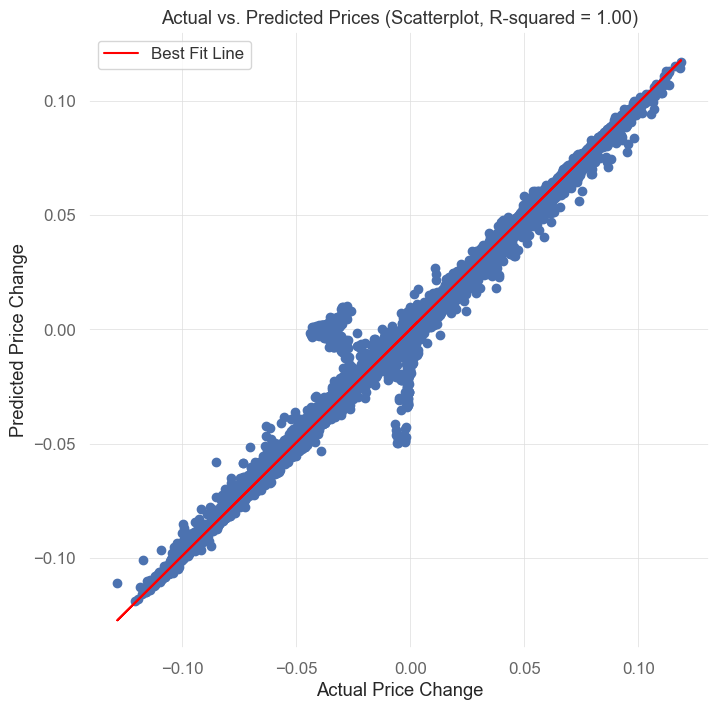

In [17]:
plot_scatter(y_val, y_pred, stats['r2'])

# Train the model on only a portion of the data then validate it

In [19]:
forecast = 8*60 # minutes into the future to predict
data_filter = len(data)*0.8 # 80% of the data will be used for training
train_df = data.iloc[:int(data_filter)] # training data
cols = df.columns

# Create the features (X) and target (y) data using numpy
X = train_df[cols].iloc[:-forecast].values # signal and volume
y = train_df['Close'].pct_change(forecast).dropna().iloc[:-forecast].values.reshape(-1, 1) # future

# Split the data into training and testing sets and make sure they are the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Create the model and fit it to the data
logging.info(f"Fitting model")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y.ravel())
logging.info(f"Model fitted")
y_val = train_df['Close'].shift(-forecast).pct_change(forecast).dropna() # future
X_val = train_df[cols][-len(y_val):] # signal and volume
y_val = y_val.values.reshape(-1, 1) # reshape to 2D
# make predictions
logging.info(f"Making predictions")
y_pred = model.predict(X_val.values)
logging.info(f"Predictions made")

# remove NaNs and infinities
valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_val.ravel()) # remove NaNs
y_pred = y_pred[valid_indices]
y_val = y_val[valid_indices]

2023-03-21 14:30:01,886 - INFO - Fitting model
2023-03-21 14:33:20,812 - INFO - Model fitted
2023-03-21 14:33:20,888 - INFO - Making predictions
2023-03-21 14:33:22,589 - INFO - Predictions made


2023-03-21 14:34:12,611 - INFO - Applying model to validation data
2023-03-21 14:34:12,634 - INFO - Making predictions
2023-03-21 14:34:12,856 - INFO - Predictions made


For a threshold of: 0.001
MSE: 0.00027047599205457103
RMSE: 0.0164
Accuracy: 4.5561%
Direction Accuracy: 51.8015% This happened 55985 times out of 108076
R-squared: -1.0168


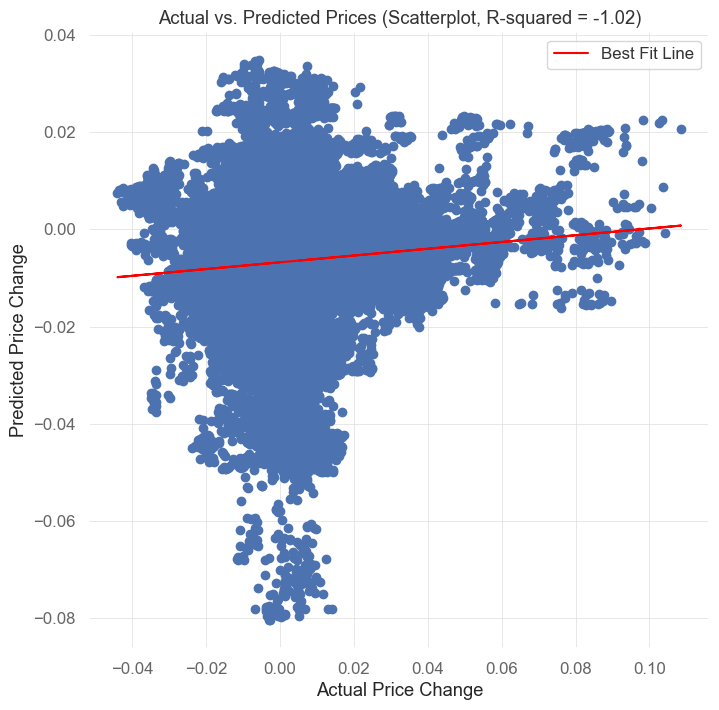

In [20]:

# Test the model on the validation data
new_df = data.iloc[int(data_filter):] # validation data
cols = new_df.columns
logging.info(f"Applying model to validation data")
y_val = new_df['Close'].shift(-forecast).pct_change(forecast).dropna() # future
X_val = new_df[cols][-len(y_val):] # signals and volume
y_val = y_val.values.reshape(-1, 1) # reshape to 2D
# make predictions
logging.info(f"Making predictions")
y_pred = model.predict(X_val.values)
logging.info(f"Predictions made")

# remove NaNs and infinities
valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_val.ravel()) # remove NaNs
y_pred = y_pred[valid_indices]
y_val = y_val[valid_indices]

# Calculate and print the results
stats = calculate_and_print_results(y_val, y_pred, threshold=0.001)
# Plot the results
plot_scatter(y_val, y_pred, stats['r2'])

We may want to give the full history to the model to make predictions. I'm not sure how much is enough. In the above example we did not give it any original data to test the predictions. In practice we wouldn't do this. We would always have historial data to let the model see in order to make predictions.

2023-03-21 14:38:11,871 - INFO - Applying model to full dataset
2023-03-21 14:38:11,915 - INFO - Making predictions
2023-03-21 14:38:13,244 - INFO - Predictions made


For a threshold of: 0.001
MSE: 5.4208800121269844e-05
RMSE: 0.0074
Accuracy: 76.7036%
Direction Accuracy: 89.6817% This happened 486342 times out of 542298
R-squared: 0.8365


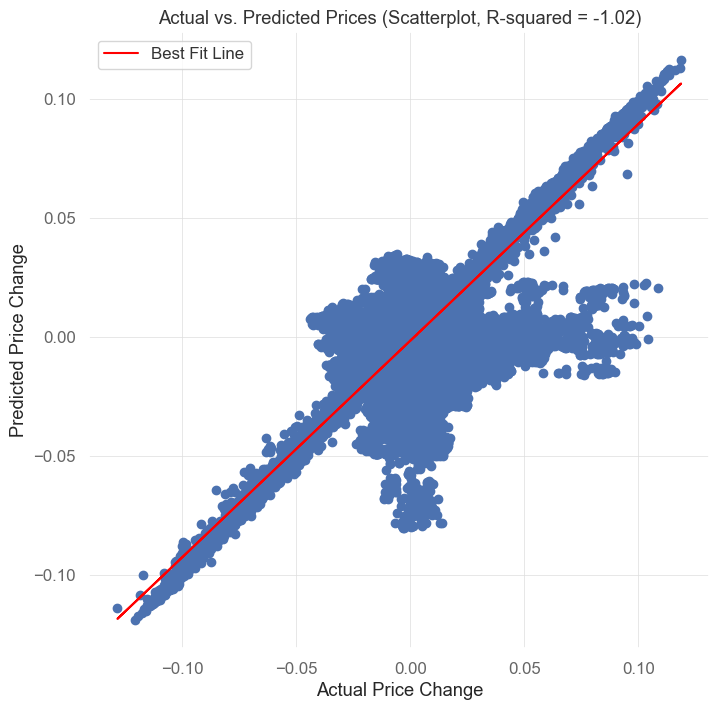

In [21]:
# Test the model on the full dataset

forecast = 8*60 # minutes into the future to predict
data_filter = len(data)*1.00 # 100% of the data will be used for training
df = data.iloc[:int(data_filter)] # full data
cols = df.columns

# Create the features (X) and target (y) data using numpy
X = df[cols].iloc[:-forecast].values # signal and volume
y = df['Close'].pct_change(forecast).dropna().iloc[:-forecast].values.reshape(-1, 1) # future

# Split the data into training and testing sets and make sure they are the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Use the model on the full dataset
logging.info(f"Applying model to full dataset")
y_val = df['Close'].shift(-forecast).pct_change(forecast).dropna() # future
X_val = df[cols][-len(y_val):] # signal and volume
y_val = y_val.values.reshape(-1, 1) # reshape to 2D
# make predictions
logging.info(f"Making predictions")
y_pred = model.predict(X_val.values)
logging.info(f"Predictions made")

# remove NaNs and infinities
valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_val.ravel()) # remove NaNs
y_pred = y_pred[valid_indices]
y_val = y_val[valid_indices]

calculate_and_print_results(y_val, y_pred, threshold=0.001)
plot_scatter(y_val, y_pred, stats['r2'])